In [1]:
import random
import numpy as np
import pandas as pd
import time
import re
import datetime
import os
import matplotlib.pyplot as plt
import scipy
from scipy import stats

## Read data

In [2]:
df = pd.read_csv('LIWC/LIWC-22 Results - topicArticleFrame8-1 - LIWC Analysis.csv',index_col=0)
df = df.drop_duplicates(subset=['text'])
print(len(df))
df.tail()

3486


,newsOutlet,dateSeen,url,title,language,sourceCountry,text,category,textCharCt,majorityTopic,...,assent,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP
3535,themoscowtimes.com,1641888000,https://www.themoscowtimes.com/2022/01/11/russ...,"Russia and West Continue to Talk , But Not Nec...",English,Russia,No one should have expected any concrete resul...,moscowtimes,NaN,-1,...,0.0,0.0,0.0,14.88,3.58,6.34,0.08,0.0,1.06,3.82
3536,themoscowtimes.com,1642060800,https://www.themoscowtimes.com/2022/01/13/sanc...,"Sanctions on Putin Would be Step Too Far , Kre...",English,Russia,The United States’ plans to levy sanctions aga...,moscowtimes,NaN,4,...,0.0,0.0,0.0,16.97,6.43,4.11,0.26,0.0,1.03,5.14
3537,themoscowtimes.com,1641801600,https://www.themoscowtimes.com/2022/01/10/news...,News From Russia : What You Missed Over the We...,English,Russia,Security talks A top Russian official said he ...,moscowtimes,NaN,-1,...,0.0,0.0,0.0,17.19,6.54,3.63,0.00,0.0,1.94,5.08
3538,themoscowtimes.com,1642147200,https://www.themoscowtimes.com/2022/01/14/russ...,"Russian Diplomat Praises Rappers Ye , Oxxxymir...",English,Russia,Will hip-hop actually save the world? A senior...,moscowtimes,NaN,-1,...,0.0,0.0,0.0,19.68,6.18,5.49,0.23,0.0,2.29,5.49
3539,themoscowtimes.com,1641801600,https://www.themoscowtimes.com/2022/01/10/kaza...,Kazakhstan Largest City Back Online After Clas...,English,Russia,Kazakhstan's largest city was back online and ...,moscowtimes,NaN,-1,...,0.0,0.0,0.0,15.43,5.09,4.22,0.00,0.0,1.16,4.95


### LIWC Columns

In [3]:
LIWCcolumns = df.columns[38:].tolist()
LIWCcolumns[:4]

['WC', 'Analytic', 'Clout', 'Authentic']

## Lasso regression over LIWC categories

In [4]:
from sklearn import linear_model

In [7]:
# sigGlobalCats = ['function', 'WPS', 'BigWords', 'det', 'article', 'Linguistic', 'Culture', 'politic', 'prep', 'pronoun', 'ipron', 'cogproc', 
#                  'Cognition', 'Comma', 'we', 'socbehav', 'comm', 'Social', 'ethnicity', 'certitude', 'risk', 'focusfuture', 'negate', 'adverb', 
#                  'insight', 'tentat', 'auxverb', 'cause', 'affiliation', 'attention', 'ppron', 'lack', 'they', 'moral', 'emo_anx', 'curiosity', 
#                  'memory', 'assent', 'sexual', 'wellness', 'friend', 'want', 'need', 'fulfill', 'relig', 'food', 'Conversation', 'allnone', 'female', 
#                  'family', 'you', 'netspeak', 'reward', 'home', 'death', 'Apostro', 'prosocial', 'discrep', 'male', 'tone_pos', 'leisure', 'OtherP', 
#                  'shehe', 'achieve', 'visual', 'illness', 'time', 'health', 'focuspast', 'tech', 'motion', 'allure', 'space', 'verb', 'Physical', 
#                  'work', 'conj', 'number', 'adj', 'Perception', 'AllPunc', 'money', 'Period', 'Tone', 'quantity', 'Lifestyle', 'Authentic', 'WC']

In [8]:
# %%time
# # create dataframe normalized across features
# normalized_df=(df-df.mean())/df.std()
# normalized_df.tail()

In [20]:
# create data arrays acc to sig global cats

# cut df so article contains certain topic

# newdf = df[df['majorityTopic'].isin([12,7,19,2,6])]
print(len(df))
newdf = df[df['category'] != 'russian']
print(len(newdf))
Y = np.array(newdf['category'])
Y = np.where(Y == 'moscowtimes', 1, Y)
Y = np.where(Y == 'western', 0, Y)

allColumns = []
# whichDf = normalized_df
whichDf = newdf
# catsOfInterest = sigGlobalCats
catsOfInterest = LIWCcolumns
for liwcCat in catsOfInterest:
    catColumn = np.array(whichDf[liwcCat]).reshape((len(whichDf),1))
    if liwcCat == 'WC':
        catColumn = np.log(catColumn)
    allColumns.append(catColumn)
X = np.concatenate(allColumns,axis=1)

3486
1136


In [21]:
# alpha testing
for alpha in [.03,.04,.05, 0.06, 0.07, 0.08, 0.09, 0.1]:
    lassoModel = linear_model.Lasso(alpha=alpha)
    lM = lassoModel.fit(X, Y)

    nonZeroCoeffs = []
    for idx, i in enumerate(lassoModel.coef_):
        if i != 0:
            cat = catsOfInterest[idx]
            nonZeroCoeffs.append({
                'LIWCcat' : cat,
                'coeff' : i
            })
    print('alpha:',alpha)
    print('\tnumber of non-zero coeffs:',len(nonZeroCoeffs))
    print('\t',[d['LIWCcat'] for d in nonZeroCoeffs])
    print()

alpha: 0.03
	number of non-zero coeffs: 12
	 ['Clout', 'Authentic', 'Tone', 'WPS', 'BigWords', 'Dic', 'prep', 'Drives', 'Social', 'politic', 'money', 'Comma']

alpha: 0.04
	number of non-zero coeffs: 10
	 ['Clout', 'Authentic', 'Tone', 'WPS', 'BigWords', 'Dic', 'prep', 'Social', 'money', 'Comma']

alpha: 0.05
	number of non-zero coeffs: 11
	 ['Clout', 'Authentic', 'Tone', 'WPS', 'BigWords', 'Dic', 'prep', 'Social', 'Lifestyle', 'money', 'Comma']

alpha: 0.06
	number of non-zero coeffs: 7
	 ['Clout', 'Authentic', 'Tone', 'WPS', 'BigWords', 'Dic', 'Comma']

alpha: 0.07
	number of non-zero coeffs: 7
	 ['Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'BigWords', 'Dic']

alpha: 0.08
	number of non-zero coeffs: 7
	 ['Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'BigWords', 'Dic']

alpha: 0.09
	number of non-zero coeffs: 6
	 ['Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'BigWords']

alpha: 0.1
	number of non-zero coeffs: 6
	 ['Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'BigWords'

In [23]:
alpha = 0.08
lassoModel = linear_model.Lasso(alpha=alpha)
lassoModel.fit(X, Y)

otherCoeffs = set()
nonZeroCoeffs = []
for idx, i in enumerate(lassoModel.coef_):
    if i != 0:
        cat = catsOfInterest[idx]
        nonZeroCoeffs.append({
            'LIWCcat' : cat,
            'coeff' : i
        })
    else:
        otherCoeffs.add(catsOfInterest[idx])
        
print('positive change')
[print(d['LIWCcat'], d['coeff']) for d in sorted(nonZeroCoeffs, key=lambda x : x['coeff'],reverse=True) if d['coeff'] > 0]
print('\nnegative change')
[print(d['LIWCcat'], d['coeff']) for d in sorted(nonZeroCoeffs, key=lambda x : x['coeff'],reverse=False) if d['coeff'] < 0]

positive change
WPS 0.014827715718540541
Authentic 0.0021945072628637425
BigWords 0.0020700224453778773
Analytic 0.00034733551611227514

negative change
Tone -0.0029809107146017383
Clout -0.002265656350431346
Dic -0.000655499663079489


[None, None, None]

In [15]:
nonZeroCoeffs[:3]

[{'LIWCcat': 'WC', 'coeff': -0.05002741877969027},
 {'LIWCcat': 'Clout', 'coeff': 0.00018300473217679268},
 {'LIWCcat': 'Tone', 'coeff': 0.0005049502743789842}]

In [14]:
print(lassoModel.intercept_)

-0.29084027964511283


### Reading scores

In [84]:
len(df[df['category']=='western'].to_dict('records'))

975

In [8]:
%%time
from readability import Readability
import json

df = df.drop_duplicates(subset=['text'])
reading_recs = []
russianrecs = random.sample(df[df['category']=='russian'].to_dict('records'),975)
westernrecs = random.sample(df[df['category']=='western'].to_dict('records'),975)

russianrecs = df[df['category']=='russian'].to_dict('records')
westernrecs = df[df['category']=='western'].to_dict('records')

for i, rec in enumerate(russianrecs+westernrecs):
    if i % 500 == 0:
        print(f'{i}/{len(russianrecs+westernrecs)} completed')
    try:
        readability = Readability(rec['text']).flesch_kincaid().score
        rec['fkscore'] = readability
        reading_recs.append(rec)
    except:
        continue
fkDf = pd.DataFrame.from_records(reading_recs)
fkDf = fkDf[['text','category','fkscore','majorityTopic']]
fkDf.sample(2)

0/3325 completed
500/3325 completed
1000/3325 completed
1500/3325 completed
2000/3325 completed
2500/3325 completed
3000/3325 completed
CPU times: user 1min 22s, sys: 1.05 s, total: 1min 23s
Wall time: 1min 25s


,text,category,fkscore,majorityTopic
1170,"MOSCOW, November 7. /TASS/. There is no respon...",russian,9.155490,-1
1923,WASHINGTON (Sputnik) - The United States and t...,russian,15.102088,12


In [9]:
with open('visualizations/histograms/reading_scores_8-4.json', 'w', encoding='utf-8') as f:
    json.dump(fkDf.to_dict('records'), f, ensure_ascii=False, indent=4)

In [97]:
# readability t-test
wArray = np.array(fkDf[fkDf['category'] == 'western']['fkscore'])
rArray = np.array(fkDf[fkDf['category'] == 'russian']['fkscore'])
coeff = scipy.stats.ttest_ind(wArray, rArray, axis=0)
coeff

Ttest_indResult(statistic=-1.4723855063312872, pvalue=0.14101360418539688)

In [98]:
fkDf[fkDf['category'] == 'western']['fkscore'].mean(),fkDf[fkDf['category'] == 'russian']['fkscore'].mean()

(13.654534774124029, 13.797873675880926)

In [99]:
fkDf[fkDf['category'] == 'western']['fkscore'].median(),fkDf[fkDf['category'] == 'russian']['fkscore'].median()

(13.320257685929327, 13.665999861337403)

# Preliminary data exploration

In [147]:
originalDf = pd.read_csv('LIWC/LIWC-22 Results - Jul21_3379_articles - LIWC Analysis.csv',index_col=0)
originalDf = originalDf.drop_duplicates(subset=['text'])

In [148]:
# compare averages
averages = []
for category in sorted(sigGlobalCats):
    russianDf = originalDf[originalDf['category'].apply(lambda x: x == 'russian')]
    westernDf = originalDf[originalDf['category'].apply(lambda x: x == 'western')]
    averages.append({
        'LIWC category': category,
        'Western media average' : westernDf[category].mean(),
        'Russian state media average' : russianDf[category].mean(),
        'MoscowTimes average': df[category].mean(),
    })

In [149]:
for a in averages:
    print(a['LIWC category'])
    print('\tWestern media:',a['Western media average'])
    print('\tMoscowTimes:',a['MoscowTimes average'])
    print('\tRussian state media:',a['Russian state media average'])

AllPunc
	Western media: 17.150379487179475
	MoscowTimes: 16.454411764705874
	Russian state media: 17.061685823754747
Apostro
	Western media: 1.621897435897435
	MoscowTimes: 1.7784803921568633
	Russian state media: 1.5107790549169875
Authentic
	Western media: 29.525620512820534
	MoscowTimes: 36.74598039215686
	Russian state media: 26.210025542784095
BigWords
	Western media: 31.044676923076892
	MoscowTimes: 31.379264705882356
	Russian state media: 32.764495530012816
Cognition
	Western media: 8.422748717948714
	MoscowTimes: 8.084117647058827
	Russian state media: 8.678765432098773
Comma
	Western media: 4.914964102564102
	MoscowTimes: 4.363480392156864
	Russian state media: 5.506802894848876
Conversation
	Western media: 0.10246153846153849
	MoscowTimes: 0.1107352941176471
	Russian state media: 0.06900808854831848
Culture
	Western media: 5.504984615384616
	MoscowTimes: 5.8347549019607845
	Russian state media: 6.4228267347807515
Lifestyle
	Western media: 4.519979487179479
	MoscowTimes: 3.653

In [156]:
# 2 t-test
allCoeffs = []
for category in sorted(LIWCcolumns):
    thisDf = originalDf[originalDf['category'].apply(lambda x: x == 'western')]
    originalArray = np.array(thisDf[category])
    moscowArray = np.array(df[category])
    coeff = scipy.stats.ttest_ind(originalArray, moscowArray, axis=0)
    allCoeffs.append({
        'LIWC category': category,
        'Western media average' : thisDf[category].mean(),
        'MoscowTimes news average': df[category].mean(),
        'p-value' : coeff.pvalue,
        't-statistic': coeff.statistic,
    })

In [157]:
random.choice(allCoeffs)

{'LIWC category': 'cause',
 'Western media average': 1.402666666666667,
 'MoscowTimes news average': 1.3258333333333336,
 'p-value': 0.1323912312691817,
 't-statistic': 1.50578287576379}

In [158]:
cdf = pd.DataFrame.from_records(allCoeffs)
cdf.to_excel('LIWC/t-test-moscowtimes-western.xlsx')

## Comparing sample to global

In [90]:
globalCats = [w.strip() for w in 
"""sexual
wellness
friend
want
need
fulfill
relig
food
Conversation
allnone
female
family
you
netspeak
reward
home
death
Apostro
prosocial
discrep
male
tone_pos
leisure
OtherP
shehe
achieve
visual
illness
time
health
focuspast
tech
motion
allure
space
verb
Physical
work
conj
number
adj
Perception
AllPunc
money
Period
Tone
quantity
Lifestyle
Authentic
WC""".split('\n')]

In [91]:
sampleCats = [w.strip() for w in 
"""emo_sad
friend
Conversation
want
netspeak
feeling
death
female
emotion
emo_neg
illness
home
prosocial
tone_pos
visual
discrep
tech
differ
Physical
conflict
tone_neg
motion
Apostro
power
space
socbehav
Affect
Period
conj
verb
money
Lifestyle
Perception
adj
quantity
WC""".split('\n')]

In [92]:
sampleCats = set(sampleCats)
globalCats = set(globalCats)

In [93]:
print('intersection', len(sampleCats.intersection(globalCats)))
print('global but not sample', len(globalCats.difference(sampleCats)))
print('sample but not global', len(sampleCats.difference(globalCats)))

intersection 26
global but not sample 24
sample but not global 10


In [94]:
# pip install matplotlib_venn

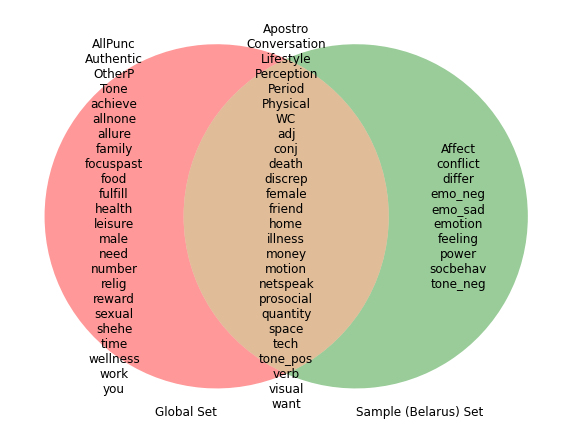

<Figure size 720x720 with 0 Axes>

In [95]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted

# Define 2 sets
A = globalCats
B = sampleCats

# Create and instance of a venn diagram with 2 areas
diagram = venn2_unweighted([A, B], ("Global Set", "Sample (Belarus) Set"))

# Set text content of areas
diagram.get_label_by_id("10").set_text("\n".join(sorted(A - B)))
diagram.get_label_by_id("11").set_text("\n".join(sorted(A & B)))
diagram.get_label_by_id("01").set_text("\n".join(sorted(B - A)))

# Modify font sizes
for text in diagram.set_labels:
    text.set_fontsize(12)
for text in diagram.subset_labels:
    text.set_fontsize(12)

plt.rcParams["figure.figsize"] = [10,10]
plt.show()
plt.savefig('test.png')